In [1]:
from astropy.io import fits
import pyregion
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as cte 
import regions
from astropy.wcs import WCS
import cmasher as cm
import seaborn as sn
from discrete_gaussian_model import DiscreteGaussianModel
from astropy.nddata import Cutout2D
from astropy.coordinates import Angle
from astropy.modeling import models, fitting
from astropy.modeling.models import Const1D
from astropy.table import QTable, Table
from astropy.coordinates import SkyCoord
FITTER = fitting.LevMarLSQFitter()

/home/roberto/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
rc_fonts = {
        "text.usetex": True,
        "font.size": 30,
        'mathtext.default': 'regular',
        'axes.titlesize': 33,
        "axes.labelsize": 33,
        "legend.fontsize": 30,
        "xtick.labelsize": 30,
        "ytick.labelsize": 30,
        'figure.titlesize': 33,
        'figure.figsize': (13,11),
        'text.latex.preamble': [r'\usepackage{amsmath,amssymb,bm,physics,lmodern}'],
        "font.family": "serif",
        "font.serif": "computer modern roman",
        }

plt.rcParams.update(rc_fonts)

/home/roberto/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [3]:
''' Resultados del combo neutro D '''
r0 = QTable.read('r0.ecsv')

''' Resultados de HST '''
HST = QTable.read('/home/roberto/Escritorio/astrofísica/Untitled Folder/Untitled Folder/m1-67-globule-parameters.ecsv')

''' Resultados JWST '''
JWST = QTable.read('JWST-combo-E.ecsv')


''' buenos ajustes en HST '''
Sel_HST = [
    2,6,9,13,14,15,17,28,32,35,43,51,52,72,82,100,111,125,127,133,135,141,143,144,147,153,156
]
''' Buenos ajustes en JWST '''
Sel_jw = [
    8,9,11,13,14,24,28,31,35,38,43,52,71,80,82,100,117,118,125,127,135,138,143,144,152,153,156
]

''' Ajustes en los que tenemos cáscaras en HSTy JWST '''
comun = []
for i in Sel_jw:
    if i in Sel_HST:
        comun.append(i)
        
comun

[9, 13, 14, 28, 35, 43, 52, 82, 100, 125, 127, 135, 143, 144, 153, 156]

# Errores para Rcore

Para las mediciones de errores en Rcore Vamos a comparar los radios medidos ls radios medidos de HST en H$\alpha$ con los obtenidos en el combo D usando los datos del JWST.

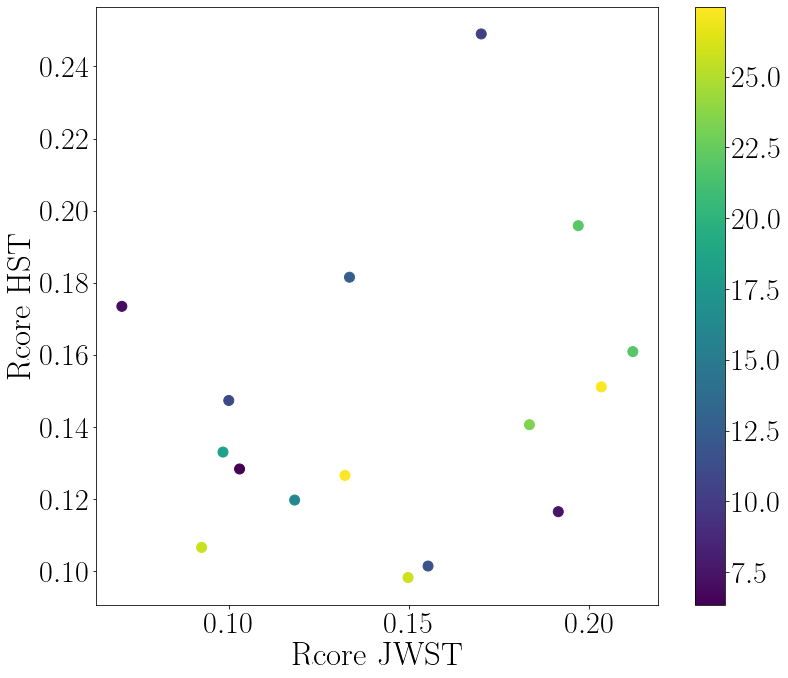

In [4]:
''' Vamos a comparar los radios de la parte neutra entre el HST y el combo nuetro '''
g = plt.scatter(r0['Rcore'][comun],HST['Rcore'][comun], c = JWST['Sep'][comun],s=100)
plt.colorbar(g)
plt.xlabel('Rcore JWST')
plt.ylabel('Rcore HST')
plt.gca().set_aspect('equal')

como la estimación de estos radios fue la sigma de la primer gaussiana ajusta, vamos a corregir estos radios tomando en cuenta la altura a anchura media y el ancho de telescopio

In [5]:
''' Correción para datos de HST '''
r_FH = 2*np.sqrt(2*np.log(2))*HST['Rcore'].value
r_CH = (np.sqrt(r_FH**2-0.067**2))/2

''' Correción para datos de JWST '''
r_FJ = 2*np.sqrt(2*np.log(2))*r0['Rcore'].value
r_CJ = (np.sqrt(r_FJ**2-0.145**2))/2

ratios_r0 = r_CH[comun]/r_CJ[comun]
delta_log_r0 = np.log(ratios_r0)
print(np.nanmean(delta_log_r0),np.nanstd(delta_log_r0))

0.16801687331948928 0.5135195949364115


Vemos que el error es casi del 50% y además en la figura anterior vemos la gran disperción de los radios en ambos telescopios, por lo que ahora vamos a comparar sus distribuciones

media 0.16798139829470016 desviacion estandar 0.04602734978856916


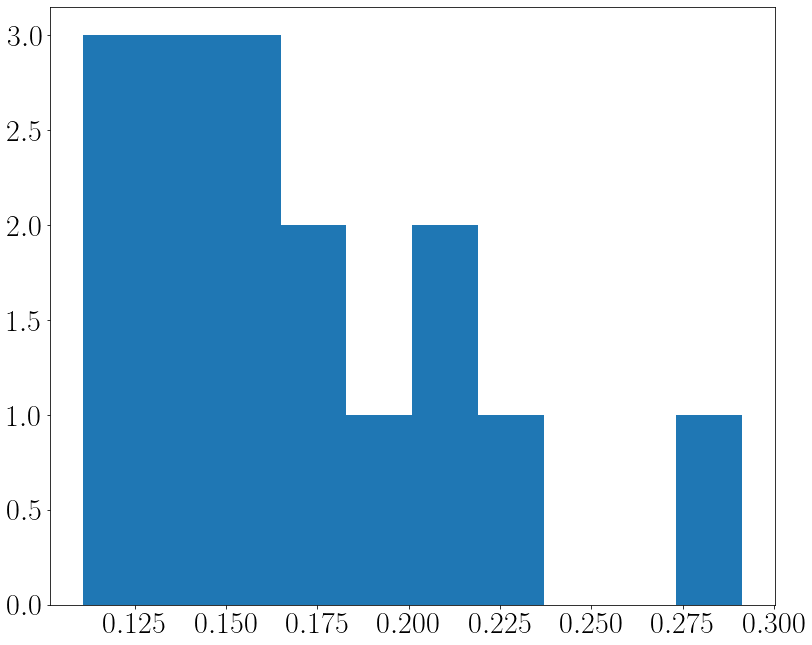

In [6]:
plt.hist(r_CH[comun])
print('media',np.nanmean(r_CH[comun]),'desviacion estandar',np.nanstd(r_CH[comun]))

media 0.15104149232183456 desviacion estandar 0.05874111313390122


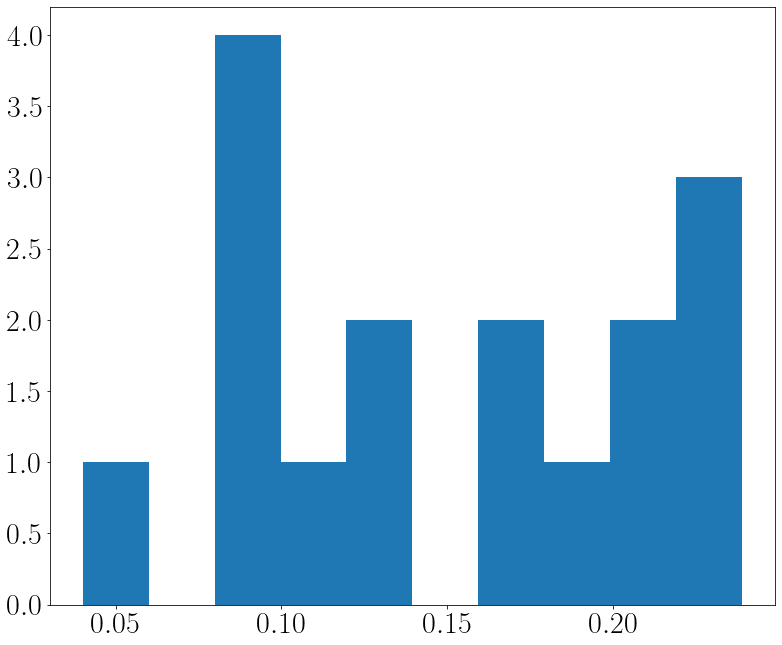

In [7]:
plt.hist(r_CJ[comun])
print('media',np.nanmean(r_CJ[comun]),'desviacion estandar',np.nanstd(r_CJ[comun]))

En estas distribuciones se parecen mucho tanot en media como en desviación estandar.

¿Podemos considerar un $r_0$ constante = 0.15 con un error de $\pm$.05?

# Rshell

Para el caso de las cáscaras como no depende de las sigmas de las gaussianas ajustadas no vamos a hacer las correcciones anteriores

Por lo que vamos a considerar el siguiente tipo de errores.

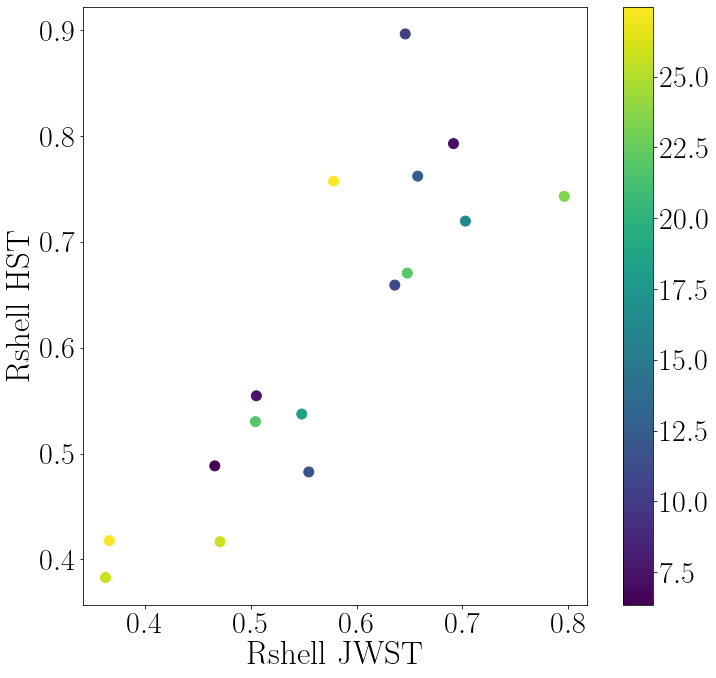

In [8]:
''' Vamos a comparar los radios de la cáscara usando los ajustes de HST y le combo ionizado de JWST '''
g = plt.scatter(JWST['Rshell'][comun],HST['Rshell'][comun], c = JWST['Sep'][comun],s=100)
plt.colorbar(g)
plt.xlabel('Rshell JWST')
plt.ylabel('Rshell HST')
plt.gca().set_aspect('equal')

In [9]:
ratios_rs = HST['Rshell'][comun]/JWST['Rshell'][comun]
delta_log_rs = np.log(ratios_rs)
print(np.nanmean(delta_log_rs),np.nanstd(delta_log_rs))

0.06233403403031197 0.12095419129631246


En este caso vemos un error de 12% 

¿Podriamos tomar ese error en el radio de la cáscara?

# Hshell

Para el caso del ancho de la cáscara que es la sigma de la segunda gaussiana ajustada, tenemos que hacer la misma correción que con el radio de la parte neutra.


In [10]:
''' Correción para datos de HST '''
h_FH = 2*np.sqrt(2*np.log(2))*HST['Hshell'].value
h_CH = (np.sqrt(h_FH**2-0.067**2))/2

''' Correción para datos de JWST '''
h_FJ = 2*np.sqrt(2*np.log(2))*JWST['Hshell'].value
h_CJ = (np.sqrt(h_FJ**2-0.145**2))/2

ratios_h = h_CH[comun]/h_CJ[comun]
delta_log_h = np.log(ratios_h)
print(np.nanmean(delta_log_h),np.nanstd(delta_log_h))

-0.04628277360833416 0.31242843995363767


<ipython-input-10-5844ca0f0bb9>:7: RuntimeWarning: invalid value encountered in sqrt
  h_CJ = (np.sqrt(h_FJ**2-0.145**2))/2


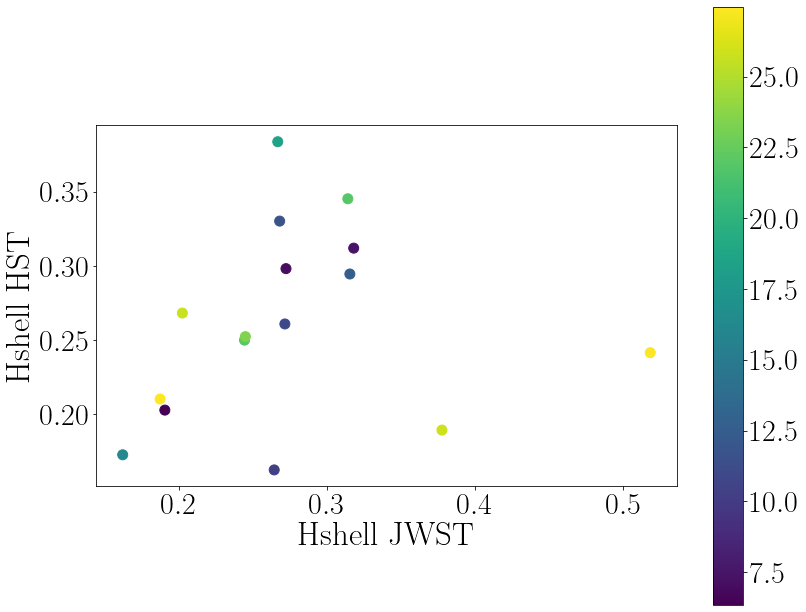

In [11]:
''' Vamos a comparar los anchos de la cáscara usando los ajustes de HST y le combo ionizado de JWST '''
g = plt.scatter(h_CJ[comun],h_CH[comun], c = JWST['Sep'][comun],s=100)
plt.colorbar(g)
plt.xlabel('Hshell JWST')
plt.ylabel('Hshell HST')
plt.gca().set_aspect('equal')

Al parecer de igual manera ell error es $\sim 30\%$, asi que tambien vmaos a ver como son sus distribuciones

media 0.27622191859123674 desviacion estandar 0.08267574240865101


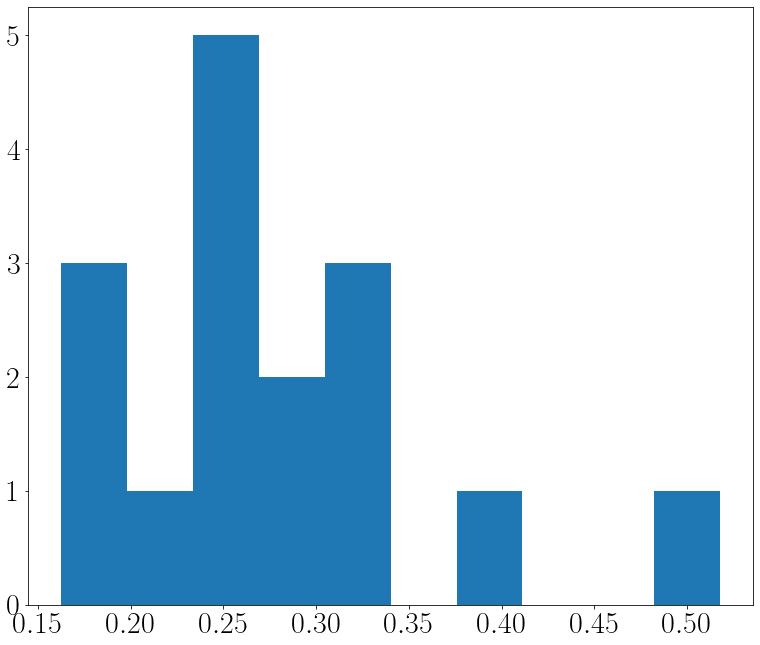

In [12]:
plt.hist(h_CJ[comun])
print('media',np.nanmean(h_CJ[comun]),'desviacion estandar',np.nanstd(h_CJ[comun]))

media 0.26093893285357295 desviacion estandar 0.06190614787144189


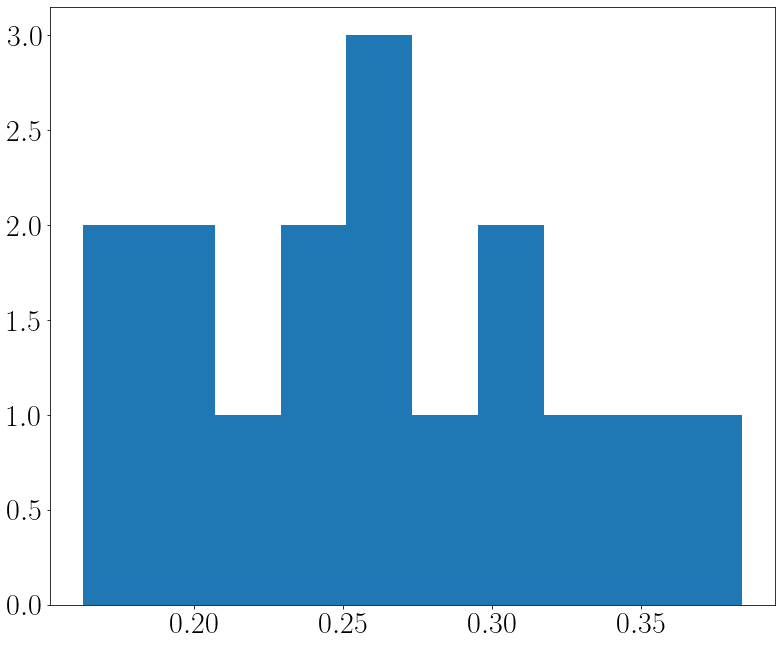

In [13]:
plt.hist(h_CH[comun])
print('media',np.nanmean(h_CH[comun]),'desviacion estandar',np.nanstd(h_CH[comun]))

Un error del 30% es mucho. En la figura de Hshell HST-Hshell JWST si quitamos los dos punto amarillos que estan alejados de los demás, el error deisminuye a un $\sim20\%$ 

# Preguntas

Para el caso de Rshell como tienee una mejor tendencia ala identidad, vamos a utlizar el error de del $\sim12\%$?

Para el caso de $r_0$ qu se pudo detectar para todos podemos hacer lo siguiente?

Text(0.5, 1.0, 'Radio neutro de todos los glóbulos')

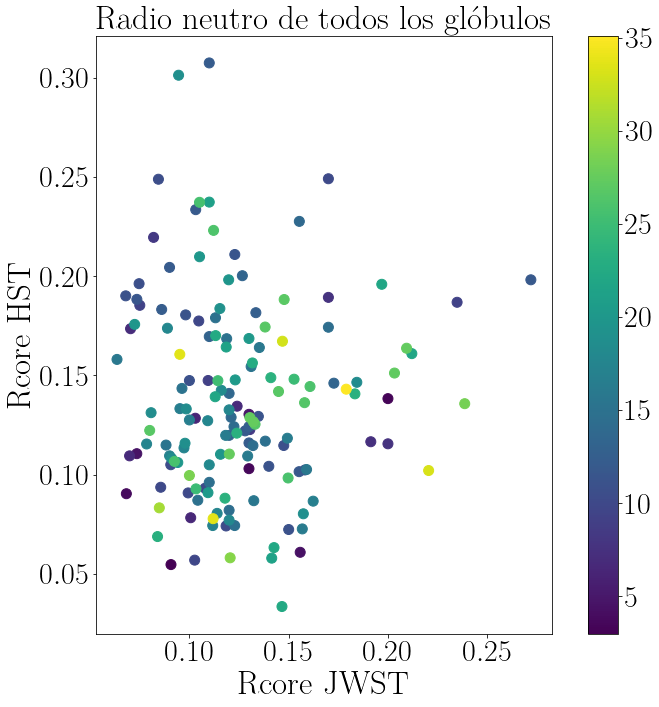

In [14]:
''' Vamos a comparar los radios de la parte neutra entre el HST y el combo nuetro '''
g = plt.scatter(r0['Rcore'],HST['Rcore'], c = JWST['Sep'],s=100)
plt.colorbar(g)
plt.xlabel('Rcore JWST')
plt.ylabel('Rcore HST')
plt.gca().set_aspect('equal')
plt.title('Radio neutro de todos los glóbulos')

In [15]:
ratios_r0 = r_CH/r_CJ
delta_log_r0 = np.log(ratios_r0)
print(np.nanmean(delta_log_r0),np.nanstd(delta_log_r0))

0.23429754788965457 0.6169911712871095


media 0.15672708719345285 desviacion estandar 0.058853917230409815


Text(0.5, 1.0, 'Radio neutro de todos los glóbulos HST')

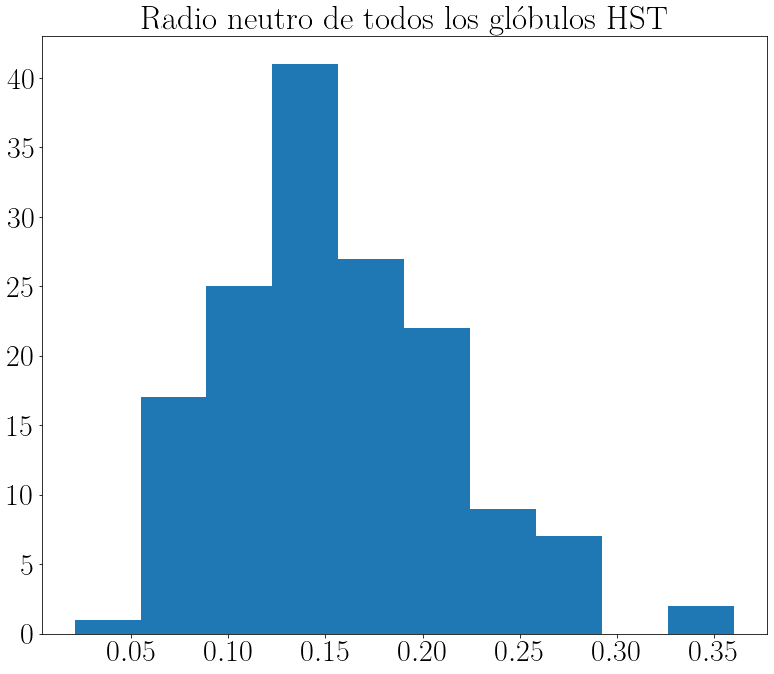

In [16]:
plt.hist(r_CH)
print('media',np.nanmean(r_CH),'desviacion estandar',np.nanstd(r_CH))
plt.title('Radio neutro de todos los glóbulos HST')

media 0.12677290810507985 desviacion estandar 0.05164208833882996


Text(0.5, 1.0, 'Radio neutro de todos los glóbulos JWST')

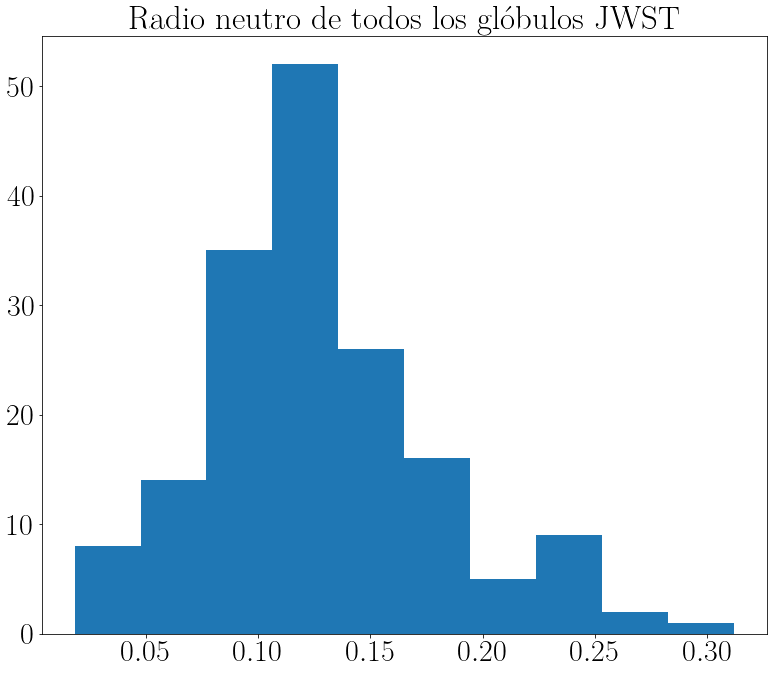

In [17]:
plt.hist(r_CJ)
print('media',np.nanmean(r_CJ),'desviacion estandar',np.nanstd(r_CJ))
plt.title('Radio neutro de todos los glóbulos JWST')

Tomar la media del radio de la parte neutra de todos los glóbulos? 

Esto ya que siguen distribuciones un poco iguales donde sus medias no son muy diferentes y sus desviaciones estandar son muy parecidas. 
¿Podemos suponer un radio cte =0.12" con un error de $\pm0.05$"?

In [18]:
1/(np.nanmean(r_CJ)/np.nanstd(r_CJ))

0.4073590257630182

Aunque este implicaría un error de casi el 40%

Y en el caso de Hshell que tenemos un error del 30%, podriamos tomar ese? ya que en la distribución con los datos del JWST se ve muy plana en general

In [19]:
r_0 = 0.12*u.arcsec
err_r_0 = .05*u.arcsec

err_r_1 = 0.12 #%

err_h = .31 #%

err_Bs = 0.6 #\unidades

In [24]:
''' Globulos a agregar  '''
add = [
    8,11,24,31,38,71,80,117,118,138,152
]

Bshell_add = [
    .5,.625,.4,.55,.55,.33,.5,.4,.29,.11,.14
]

glo = []
for i in Sel_jw:
    glo.append(i)

for i in Sel_HST:
    if i not in glo:
        glo.append(i)

for i in add:
    if i not in glo:
        glo.append(i)

Glo = sorted(glo)

R1 = []
for i in Glo:
    if i in Sel_jw:
        R1.append(JWST['Rshell'][i])
    elif i in Sel_HST:
        R1.append(HST['Rshell'][i])

H = []
for i in Glo:
    if i in Sel_jw:
        H.append(JWST['Hshell'][i])
    elif i in Sel_HST:
        H.append(HST['Hshell'][i])

Bs = []
for i in Glo:
    if i in Sel_HST:
        Bs.append(HST['Bshell'][i])
    elif i in add:
        Bs.append(Bshell_add[add.index(i)])

In [39]:
'''   Densidad   '''
D = 5429*u.pc                      # conversation with Jane
v_inf = 710*u.km*(1/u.second)      # Hanmman
M_loss = (2.0E-5)*u.M_sun*(1/u.yr) #Crowther 1999
L = 10**(49.1)*(1/u.second)        # Hanmman

E = (cte.h*cte.c/(6562.8*u.AA)).cgs
EM = np.array(Bs)*4*np.pi*0.0137/(1.17e-13*E.value*u.cm**5)
n  = np.sqrt(EM.value/(2*np.sqrt(2*np.array([R1[i].value for i in range(len(R1))])*np.array([H[i].value for i in range(len(H))])*D.value**2*u.AU**2))).cgs
n

'''   Presion   '''
cs2 = (cte.k_B*6000*u.K/(0.6*cte.m_p)).to('km**2/s**2')
Pg = (n*cte.m_p*cs2).cgs
Pr = ((M_loss*v_inf)/(4*np.pi*((HST['Sep'][Glo].value*D.value)*u.AU)**2)).cgs

'''   cos(i)   '''
cos = (Pg/Pr)**(2/5)

R = HST['Sep'][Glo]/cos

In [44]:
err_n = 0.5*np.log(err_Bs)+(1/4)*np.log(err_r_1*np.array([R1[i].value for i in range(len(R1))]))+(1/4)*np.log(err_h*np.array([H[i].value for i in range(len(H))]))
err_cos = (2/5)*np.log(err_n)


<ipython-input-44-952f1aa796aa>:2: RuntimeWarning: invalid value encountered in log
  err_cos = (2/5)*np.log(err_n)


(1e-10, 6e-09)

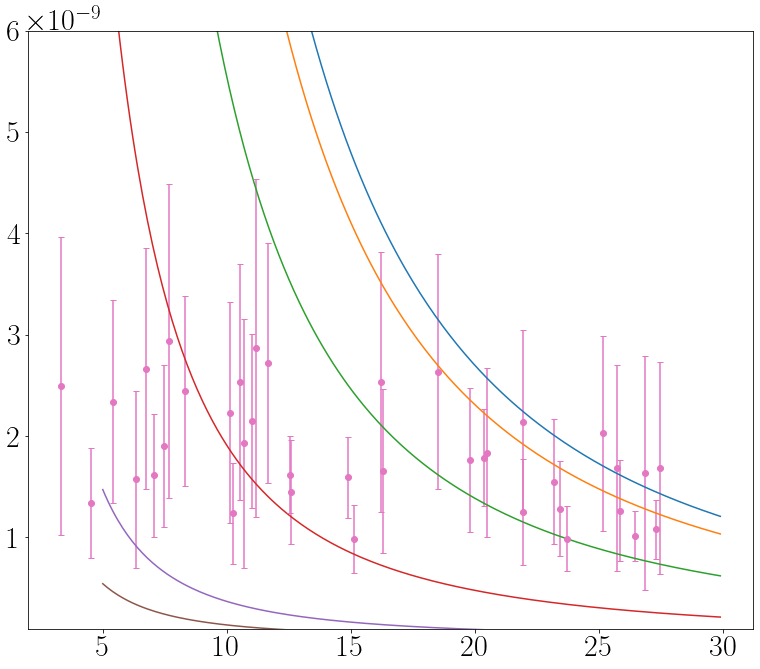

In [146]:
rang = np.arange(5,30,0.1) #the range in what we see the globules
distances = rang*D.value*u.AU
P_r = (M_loss*v_inf)/(4*np.pi*(distances.to('cm'))**2)
fig, ax = plt.subplots()
ax.plot(rang,P_r.cgs)
ax.plot(rang,P_r.cgs*np.cos(20*u.deg)**(5/2))
ax.plot(rang,P_r.cgs*np.cos(40*u.deg)**(5/2))
ax.plot(rang,P_r.cgs*np.cos(60*u.deg)**(5/2))
ax.plot(rang,P_r.cgs*np.cos(75*u.deg)**(5/2))
ax.plot(rang,P_r.cgs*np.cos(80*u.deg)**(5/2))
ax.errorbar(HST['Sep'][Glo].value,Pg.value,yerr=abs(err_n)*Pg.value,marker='o',capsize=3,linestyle='')
#plt.colorbar(g)
plt.ylim(1e-10,0.6e-8)

In [69]:
Pg

<Quantity [2.49079092e-09, 1.33997584e-09, 2.34004856e-09, 1.57335227e-09,
           2.66577886e-09, 1.61364227e-09, 1.90291056e-09, 2.93719066e-09,
           2.44545462e-09, 2.23052181e-09, 1.23668492e-09, 2.53586686e-09,
           1.92745377e-09, 2.14858510e-09, 2.86799766e-09, 2.71924411e-09,
           1.61824960e-09, 1.44634571e-09, 1.59298727e-09, 9.82023876e-10,
           2.53239352e-09, 1.65427914e-09, 2.63573294e-09, 1.76394003e-09,
           1.78686667e-09, 1.83519703e-09, 2.13947249e-09, 1.25321930e-09,
           1.54677709e-09, 1.28213509e-09, 9.88306853e-10, 2.02544603e-09,
           1.68367122e-09, 1.26371920e-09, 1.01229611e-09, 1.63755176e-09,
           1.07763762e-09, 1.68420317e-09] cm(1/2) dyn>

In [83]:
abs(err_n)

array([0.58993903, 0.40313072, 0.42635091, 0.55601792, 0.44510372,
       0.37657622, 0.41848596, 0.52791821, 0.38445715, 0.48998655,
       0.40051534, 0.45905967, 0.63842128, 0.39811631, 0.58213824,
       0.43531438, 0.23602725, 0.35453165, 0.24954798, 0.33960964,
       0.50534414, 0.48781391, 0.43942543, 0.40330502, 0.26821462,
       0.45569466, 0.42188344, 0.41798087, 0.39847212, 0.3659072 ,
       0.32148104, 0.4755882 , 0.60536999, 0.39498184, 0.24322553,
       0.70586436, 0.2666912 , 0.61982832])

In [88]:
from scipy.optimize import fsolve

def find_root(x):
    """Should be called with vector argument of same length as P_P_0"""
    return ((1+x**2)/2)*(np.e**((1-x**2)/2)) - P_P0 #equation to find the root

#M0 = fsolve(func_to_find_M0, 1.5 * np.ones_like(P_P_0)) 

P_P0 = np.arange(0.01,1.01,0.01)
M0 = fsolve(find_root,1.5 * np.ones_like(P_P0))
alpha=2      #spherical case
rho1 = np.exp((1-M0**2)/2)
r1 = (M0**(-1/alpha))*np.exp((M0**2-1)/(2*alpha))
rho2 = (M0**2)*rho1
h2 = (3/(4*M0**2)) * r1

/home/roberto/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<ipython-input-121-156384d29bd9>:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(-6,20)


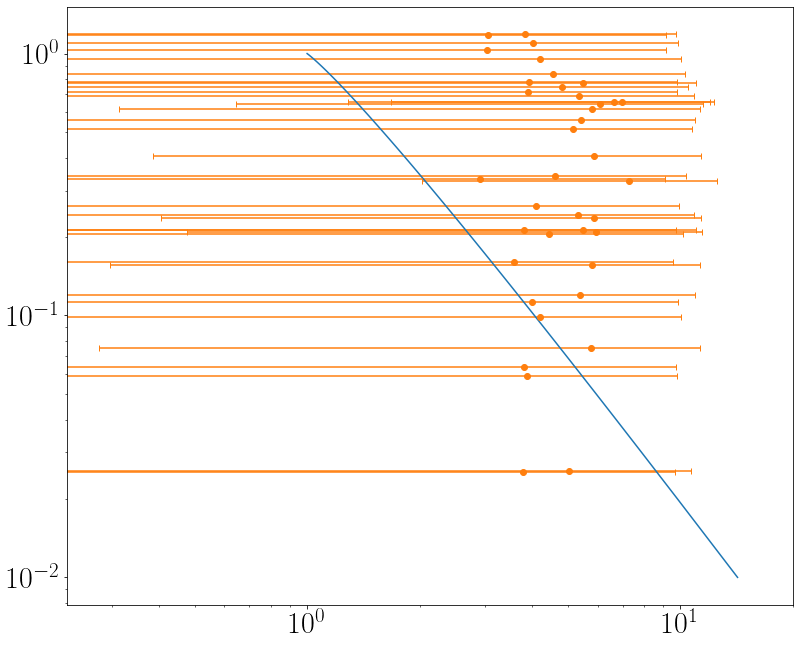

In [121]:
x = np.array([R1[i].value for i in range(len(R1))])/r_0
xer = np.log(err_r_1*np.array([R1[i].value for i in range(len(R1))]))+np.log(err_r_0.value)

plt.plot(r1,P_P0,label=rf'$P/P_0$')

plt.errorbar(x.value,Pg.value/Pr.cgs.value,xerr=xer,linestyle='',marker='o',capsize=3)
plt.xscale('log')
plt.xlim(-6,20)
plt.yscale('log')

In [107]:
l_s = 2*np.sqrt(2*np.array([R1[i].value for i in range(len(R1))])*np.array([H[i].value for i in range(len(H))]))
Bs_B0 = np.array(Bs)/HST['Bcore'][Glo].value
f_o = 0.5*np.sqrt(Bs_B0/(l_s/r_CJ[Glo]))
f_o

array([0.16121741, 0.05908067,        nan, 0.08977851, 0.06981278,
       0.05378559, 0.24997384, 0.19861947, 0.09498672, 0.15831069,
       0.08907469, 0.09653257, 0.06294296, 0.11823241, 0.26779452,
       0.25542532, 0.0810306 , 0.12665751, 0.19069131, 0.07331363,
       0.22269122, 0.09572987, 0.12604855, 0.04928015, 0.16167239,
              nan, 0.18356818, 0.13426982, 0.09277845, 0.15625805,
              nan, 0.13526489, 0.10589942, 0.24900372, 0.14327707,
       0.21554303, 0.27558435, 0.17583518])

In [140]:
err_ls = np.sqrt((err_r_1*np.array([R1[i].value for i in range(len(R1))]))**2+(err_h*np.array([H[i].value for i in range(len(H))]))**2)
err_f = np.sqrt((err_Bs*np.array(Bs))**2+(err_r_1)**2+(abs(err_ls))**2)

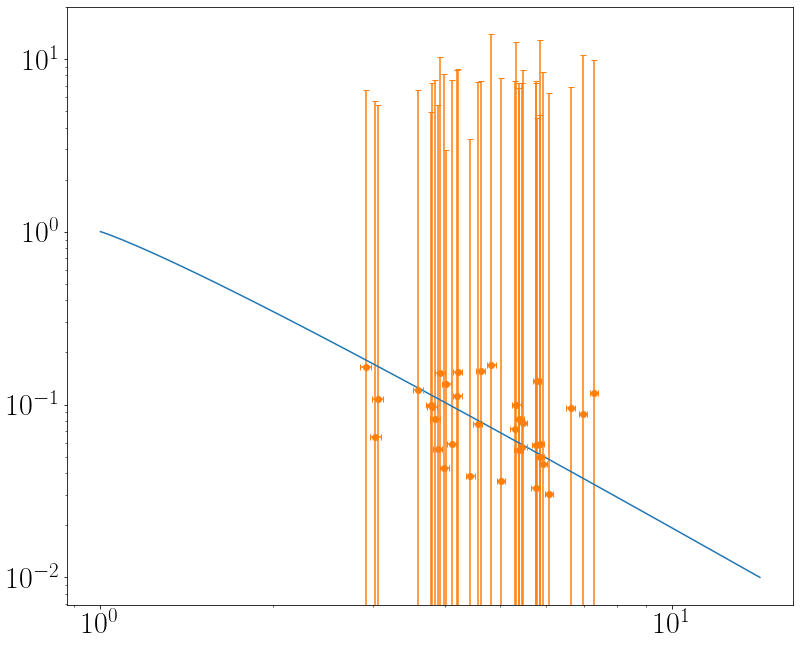

In [141]:
x = np.array([R1[i].value for i in range(len(R1))])/r_0
xer = np.sqrt((err_r_1*np.array([R1[i].value for i in range(len(R1))]))**2+(err_r_0.value)**2)

plt.plot(r1,P_P0,label=rf'$P/P_0$')

plt.errorbar(x.value,f_o/1.63,xerr=abs(xer),yerr = abs(err_f),linestyle='',marker='o',capsize=3)
plt.xscale('log')
plt.yscale('log')

In [143]:
err_ls

array([ 4.82338566,  7.6726365 ,  9.20984348,  5.37280272,  8.14646365,
        7.42271481,  8.58985301,  6.50371864,  7.17189966,  7.15406923,
        7.22074616,  7.47792183,  3.386669  ,  7.4037134 ,  6.45683571,
        7.31402947, 12.77809974,  8.52350936,  9.7660634 ,  8.3581513 ,
        4.41216932,  4.68124623,  7.28157159,  6.32511695, 12.36288688,
        7.9924674 ,  8.48816526,  6.71341501,  7.16817467,  6.72861656,
       10.33189498,  7.49011473,  5.6641649 , 10.12328221, 10.45786741,
        2.84767737, 13.77250602,  5.29422072])

In [144]:
err_f

array([ 4.83109707,  7.67426671,  9.21550959,  5.37516125,  8.15597297,
        7.42535715,  8.5930547 ,  6.51625397,  7.18174581,  7.15909957,
        7.2222822 ,  7.48616156,  3.39141028,  7.40952001,  6.46637668,
        7.32582812, 12.78038747,  8.52538082,  9.76880741,  8.35924891,
        4.42398441,  4.68466069,  7.29199312,  6.32877313, 12.36579848,
        7.9952618 ,  8.4927835 ,  6.71505747,  7.17051854,  6.73045395,
       10.33280261,  7.49384439,  5.66647602, 10.12442201, 10.45886933,
        2.85144216, 13.7733071 ,  5.29663207])

In [142]:
xer

array([0.07388243, 0.08781254, 0.07418481, 0.07501853, 0.07618347,
       0.09688112, 0.07859294, 0.07192033, 0.09708444, 0.0741064 ,
       0.09224018, 0.07750421, 0.08107327, 0.09124499, 0.06524714,
       0.08326358, 0.09824554, 0.09342972, 0.11614535, 0.0989926 ,
       0.09725358, 0.09803932, 0.08263006, 0.10078695, 0.09168465,
       0.07519055, 0.07851441, 0.09243583, 0.09325884, 0.10782965,
       0.08956715, 0.07458231, 0.06630365, 0.07546462, 0.11216435,
       0.07654205, 0.08554098, 0.06658361])

In [122]:
+np.log(err_r_0.value)

-2.995732273553991

In [123]:
err_r_0

<Quantity 0.05 arcsec>

In [148]:
r0

PA,Sep,Bcore,Bbg,Rcore
deg,arcsec,,,arcsec
float64,float64,float64,float64,float64
296.28,2.98,6.28,1.50,0.09
66.87,3.15,15.00,3.98,0.12
30.92,3.31,1.19,2.06,0.20
71.97,3.52,15.00,2.43,0.13
16.83,3.80,8.04,2.89,0.07
57.69,4.38,3.74,1.32,0.16
337.92,4.52,7.56,0.00,0.07
49.98,4.95,8.66,1.20,0.13


# Para n_0

In [200]:
EM_0 = (HST['Bcore'].value*4*np.pi*0.037)/(1.17e-13*E.value*u.cm**5)
n_0 = np.sqrt(EM_0/(2*np.sqrt(2)*r0['Rcore'].value*D.value*u.AU)).cgs
n_0[Glo]

<Quantity [ 5786.70546981,  6435.32939842,            nan,  6024.8870358 ,
           10077.77374575,  8012.34035509,  2844.30244468,  5538.8088891 ,
            8030.48205782,  4792.90885364,  5146.99535785,  8341.51067909,
            8841.23269067,  6194.12402603,  3897.21046582,  3916.70565126,
            7196.66058432,  4130.25267279,  2881.29489494,  4756.33521256,
            4094.92708024,  6131.23860659,  7091.41436047,  9973.55695664,
            3858.07755428,            nan,  4377.86904568,  3492.95189304,
            5278.19928486,  3057.87445154,            nan,  5277.96342355,
            5272.88865125,  1860.55004104,  2603.53924595,  2781.3820459 ,
            1465.85136815,  3459.89400314] 1 / cm3>

In [215]:
F0_1 = n_0*10*u.km/u.second+n_0**2*.12*r0['Rcore'].value*D.value*u.AU*2.3e-13*u.cm**3/u.second
F0_1[Glo].cgs

<Quantity [2.07990004e+10, 1.32583563e+10,            nan, 1.44050908e+10,
           2.59826237e+10, 1.81366684e+10, 6.31464214e+09, 1.92924312e+10,
           1.98768097e+10, 9.90928399e+09, 1.52420997e+10, 2.15041662e+10,
           2.19214028e+10, 1.47944345e+10, 8.66360614e+09, 9.25545649e+09,
           2.22891100e+10, 9.23411427e+09, 4.82083588e+09, 1.07796474e+10,
           8.95693710e+09, 1.60968293e+10, 1.81836572e+10, 2.61235394e+10,
           7.50677081e+09,            nan, 1.34874836e+10, 8.87778457e+09,
           1.05213179e+10, 6.90127414e+09,            nan, 1.24177680e+10,
           1.10354402e+10, 3.02222496e+09, 5.00428154e+09, 5.34322561e+09,
           2.44506084e+09, 7.00776978e+09] 1 / (cm2 s)>

In [216]:
F0_2 = n_0**2*.12*r0['Rcore'].value*D.value*u.AU*2.3e-13*u.cm**3/u.second
F0_2[Glo].cgs

<Quantity [1.50122949e+10, 6.82302688e+09,            nan, 8.38020373e+09,
           1.59048499e+10, 1.01243281e+10, 3.47033969e+09, 1.37536223e+10,
           1.18463276e+10, 5.11637513e+09, 1.00951043e+10, 1.31626555e+10,
           1.30801701e+10, 8.60031048e+09, 4.76639567e+09, 5.33875084e+09,
           1.50924494e+10, 5.10386160e+09, 1.93954099e+09, 6.02331217e+09,
           4.86201002e+09, 9.96559074e+09, 1.10922428e+10, 1.61499825e+10,
           3.64869325e+09,            nan, 9.10961458e+09, 5.38483268e+09,
           5.24311860e+09, 3.84339969e+09,            nan, 7.13980457e+09,
           5.76255154e+09, 1.16167492e+09, 2.40074229e+09, 2.56184356e+09,
           9.79209471e+08, 3.54787577e+09] 1 / (cm2 s)>

In [204]:
(r0['Rcore'].value*D.value*u.AU).cgs

<Quantity [7.36801062e+15, 9.74600208e+15, 1.62433368e+16, 1.05581689e+16,
           5.54230787e+15, 1.26537273e+16, 5.96934166e+15, 1.05581689e+16,
           8.93383524e+15, 8.36464815e+15, 8.17460955e+15, 5.67402553e+15,
           1.00735693e+16, 5.71397517e+15, 1.55421593e+16, 1.62433368e+16,
           1.38068363e+16, 6.65566456e+15, 1.05946254e+16, 8.88713264e+15,
           6.09171829e+15, 1.90724161e+16, 8.33696496e+15, 8.50436919e+15,
           8.06965480e+15, 6.94801135e+15, 1.23732687e+16, 8.76172169e+15,
           1.38068363e+16, 7.35859762e+15, 9.62191232e+15, 6.85401439e+15,
           6.06287576e+15, 1.19814841e+16, 1.28461982e+16, 8.12166840e+15,
           1.21825026e+16, 5.51673334e+15, 1.13703358e+16, 7.96764695e+15,
           1.09427460e+16, 9.97867108e+15, 5.97192949e+15, 1.26092339e+16,
           2.20900830e+16, 8.37976498e+15, 1.04013171e+16, 7.30950156e+15,
           1.05581689e+16, 8.93383524e+15, 6.98706816e+15, 1.05581689e+16,
           1.08401818e+16

In [205]:
EM_0

<Quantity [4.14074028e+23,            nan, 1.53844863e+24, 7.07128639e+23,
           8.46705187e+23, 1.80722142e+23, 6.99218634e+23, 5.53302484e+23,
                      nan, 8.58796940e+23, 4.92052939e+23, 1.62991699e+24,
           5.79860254e+23, 1.03753348e+24, 3.55637787e+23, 1.40946081e+24,
           9.42017052e+23, 1.21400270e+24, 5.07016134e+23, 8.32998741e+23,
           5.93233831e+23, 6.61735480e+23, 1.91500165e+23, 2.64881322e+23,
           5.24322254e+23, 9.35777067e+23, 3.17980342e+23, 4.58472660e+23,
           1.03453865e+24, 5.73558224e+23, 2.80858375e+23, 1.34889898e+24,
           1.34044594e+24, 2.14068520e+23, 5.93162160e+23, 8.81353313e+23,
           5.87729819e+23, 1.10585787e+24, 4.88456624e+23, 1.14484655e+24,
           3.07302319e+23, 9.43623800e+23, 9.40608509e+23, 5.47111148e+23,
           8.23755273e+23, 4.38677573e+23, 4.62873867e+23, 6.41191545e+23,
           1.25408060e+24, 8.44057100e+23, 5.34373990e+23, 1.54666280e+24,
           5.23039876e+23

In [206]:
HST['Bcore'].value*0.037*E*4*np.pi

<Quantity [4.43852815e-13,            nan, 1.64908859e-12, 7.57982911e-13,
           9.07597327e-13, 1.93719060e-13, 7.49504045e-13, 5.93094105e-13,
                      nan, 9.20558677e-13, 5.27439703e-13, 1.74713504e-12,
           6.21561819e-13, 1.11214934e-12, 3.81214039e-13, 1.51082440e-12,
           1.00976369e-12, 1.30130962e-12, 5.43478999e-13, 8.92905160e-13,
           6.35897178e-13, 7.09325231e-13, 2.05272201e-13, 2.83930680e-13,
           5.62029716e-13, 1.00307495e-12, 3.40848400e-13, 4.91444444e-13,
           1.10893913e-12, 6.14806569e-13, 3.01056748e-13, 1.44590718e-12,
           1.43684623e-12, 2.29463595e-13, 6.35820353e-13, 9.44737227e-13,
           6.29997336e-13, 1.18538738e-12, 5.23584753e-13, 1.22718000e-12,
           3.29402451e-13, 1.01148599e-12, 1.00825385e-12, 5.86457509e-13,
           8.82996933e-13, 4.70225763e-13, 4.96162172e-13, 6.87303847e-13,
           1.34426978e-12, 9.04758798e-13, 5.72804339e-13, 1.65789350e-12,
           5.60655114e-13

In [224]:
u_0 = 10*u.km/u.second
h_ = .12*r0['Rcore'].value*D.value*u.AU
F = (HST['Bcore'].value*0.037/E).value/u.cm**2/u.second
nn_0 = (-u_0+np.sqrt(u_0**2-4*h_*2.3e-13*u.cm**3/u.second*-1*(F)))/(2*h_*2.3e-13*u.cm**3/u.second)

In [225]:
nn_0[Glo].cgs

<Quantity [4646.15101247, 3945.45738896,           nan, 4105.20173476,
           7156.01923041, 5273.78435129, 1847.3165365 , 4408.78452694,
           5581.11703182, 2947.1875921 , 3883.88477337, 5922.85621806,
           6150.41391829, 4217.92503896, 2533.50253757, 2649.99266111,
           5520.25189107, 2695.68087789, 1395.5740449 , 3133.24292676,
           2631.37760967, 4392.87455285, 5021.5563349 , 7137.71720071,
           2245.43041836,           nan, 3351.84157331, 2462.2016149 ,
           3143.2516129 , 2008.69033143,           nan, 3561.44740241,
           3275.11645116,  860.12788692, 1496.96844826, 1598.34860683,
            706.70354723, 2090.25428066] 1 / cm3>

In [226]:
F[Glo]

<Quantity [1.43238247e+10, 6.51011996e+09,            nan, 7.99588402e+09,
           1.51754467e+10, 9.66002207e+09, 3.31118844e+09, 1.31228753e+10,
           1.13030500e+10, 4.88173599e+09, 9.63213852e+09, 1.25590105e+10,
           1.24803080e+10, 8.20589658e+09, 4.54780674e+09, 5.09391345e+09,
           1.44003033e+10, 4.86979633e+09, 1.85059281e+09, 5.74708051e+09,
           4.63903617e+09, 9.50856450e+09, 1.05835478e+10, 1.54093374e+10,
           3.48136263e+09,            nan, 8.69184378e+09, 5.13788196e+09,
           5.00266695e+09, 3.66713974e+09,            nan, 6.81237009e+09,
           5.49827848e+09, 1.10840001e+09, 2.29064323e+09, 2.44435633e+09,
           9.34302508e+08, 3.38516868e+09] 1 / (cm2 s)>

In [227]:
nn_01 = np.sqrt(F/(h_*2.3e-13*u.cm**3/u.second))
nn_01[Glo].cgs

<Quantity [5652.45785487, 6286.0341513 ,           nan, 5885.1137712 ,
           9843.97627734, 7826.45953078, 2778.31657044, 5410.31230553,
           7844.1803584 , 4681.7166415 , 5027.58858063, 8147.99332807,
           8636.12213026, 6050.42457883, 3806.79784456, 3825.84075502,
           7029.70297364, 4034.43363149, 2814.45082113, 4645.99148391,
           3999.92756856, 5988.99805818, 6926.89839031, 9742.17724657,
           3768.57278985,           nan, 4276.30547363, 3411.91779459,
           5155.74866613, 2986.9338526 ,           nan, 5155.51827665,
           5150.5612356 , 1817.38655073, 2543.1389135 , 2716.85588195,
           1431.8446175 , 3379.62682516] 1 / cm3>

In [228]:
F0_1[Glo].cgs

<Quantity [2.07990004e+10, 1.32583563e+10,            nan, 1.44050908e+10,
           2.59826237e+10, 1.81366684e+10, 6.31464214e+09, 1.92924312e+10,
           1.98768097e+10, 9.90928399e+09, 1.52420997e+10, 2.15041662e+10,
           2.19214028e+10, 1.47944345e+10, 8.66360614e+09, 9.25545649e+09,
           2.22891100e+10, 9.23411427e+09, 4.82083588e+09, 1.07796474e+10,
           8.95693710e+09, 1.60968293e+10, 1.81836572e+10, 2.61235394e+10,
           7.50677081e+09,            nan, 1.34874836e+10, 8.87778457e+09,
           1.05213179e+10, 6.90127414e+09,            nan, 1.24177680e+10,
           1.10354402e+10, 3.02222496e+09, 5.00428154e+09, 5.34322561e+09,
           2.44506084e+09, 7.00776978e+09] 1 / (cm2 s)>

In [229]:
F0_2[Glo].cgs

<Quantity [1.50122949e+10, 6.82302688e+09,            nan, 8.38020373e+09,
           1.59048499e+10, 1.01243281e+10, 3.47033969e+09, 1.37536223e+10,
           1.18463276e+10, 5.11637513e+09, 1.00951043e+10, 1.31626555e+10,
           1.30801701e+10, 8.60031048e+09, 4.76639567e+09, 5.33875084e+09,
           1.50924494e+10, 5.10386160e+09, 1.93954099e+09, 6.02331217e+09,
           4.86201002e+09, 9.96559074e+09, 1.10922428e+10, 1.61499825e+10,
           3.64869325e+09,            nan, 9.10961458e+09, 5.38483268e+09,
           5.24311860e+09, 3.84339969e+09,            nan, 7.13980457e+09,
           5.76255154e+09, 1.16167492e+09, 2.40074229e+09, 2.56184356e+09,
           9.79209471e+08, 3.54787577e+09] 1 / (cm2 s)>

In [230]:
(n_0*10*u.km/u.second)[Glo].cgs/F[Glo].cgs

<Quantity [0.40399164, 0.98851165,        nan, 0.75349855, 0.66408416,
           0.82943292, 0.85899746, 0.42207281, 0.71047036, 0.98180419,
           0.53435645, 0.66418534, 0.70841463, 0.75483818, 0.85694285,
           0.76889914, 0.49975757, 0.84813663, 1.55695779, 0.82760894,
           0.88271075, 0.64481222, 0.67004132, 0.64724113, 1.10820905,
                  nan, 0.50367553, 0.67984277, 1.05507709, 0.83385818,
                  nan, 0.7747617 , 0.9590072 , 1.67859078, 1.13659745,
           1.13787913, 1.56892586, 1.02207433]>

In [233]:
(n_0*u_0)[Glo].cgs/F[Glo].cgs

<Quantity [0.40399164, 0.98851165,        nan, 0.75349855, 0.66408416,
           0.82943292, 0.85899746, 0.42207281, 0.71047036, 0.98180419,
           0.53435645, 0.66418534, 0.70841463, 0.75483818, 0.85694285,
           0.76889914, 0.49975757, 0.84813663, 1.55695779, 0.82760894,
           0.88271075, 0.64481222, 0.67004132, 0.64724113, 1.10820905,
                  nan, 0.50367553, 0.67984277, 1.05507709, 0.83385818,
                  nan, 0.7747617 , 0.9590072 , 1.67859078, 1.13659745,
           1.13787913, 1.56892586, 1.02207433]>

In [232]:
F0_2[Glo].cgs/F[Glo].cgs

<Quantity [1.04806469, 1.04806469,        nan, 1.04806469, 1.04806469,
           1.04806469, 1.04806469, 1.04806469, 1.04806469, 1.04806469,
           1.04806469, 1.04806469, 1.04806469, 1.04806469, 1.04806469,
           1.04806469, 1.04806469, 1.04806469, 1.04806469, 1.04806469,
           1.04806469, 1.04806469, 1.04806469, 1.04806469, 1.04806469,
                  nan, 1.04806469, 1.04806469, 1.04806469, 1.04806469,
                  nan, 1.04806469, 1.04806469, 1.04806469, 1.04806469,
           1.04806469, 1.04806469, 1.04806469]>

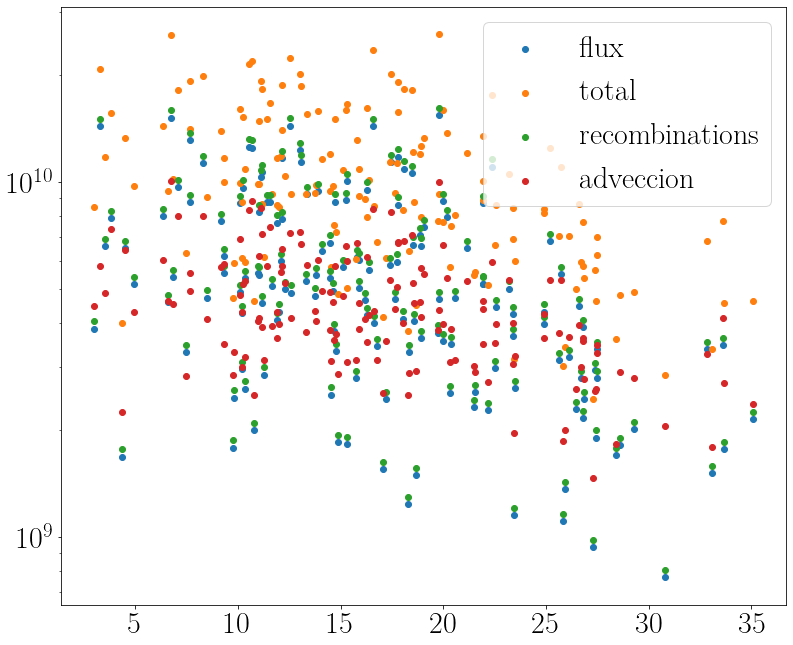

In [237]:
F_ad = n_0*u_0
plt.scatter(r0['Sep'],F.cgs,label='flux')
plt.scatter(r0['Sep'],F0_1.cgs,label='total')
plt.scatter(r0['Sep'],F0_2.cgs,label='recombinations')
plt.scatter(r0['Sep'],F_ad.cgs,label='adveccion')
plt.legend()
plt.yscale('log')

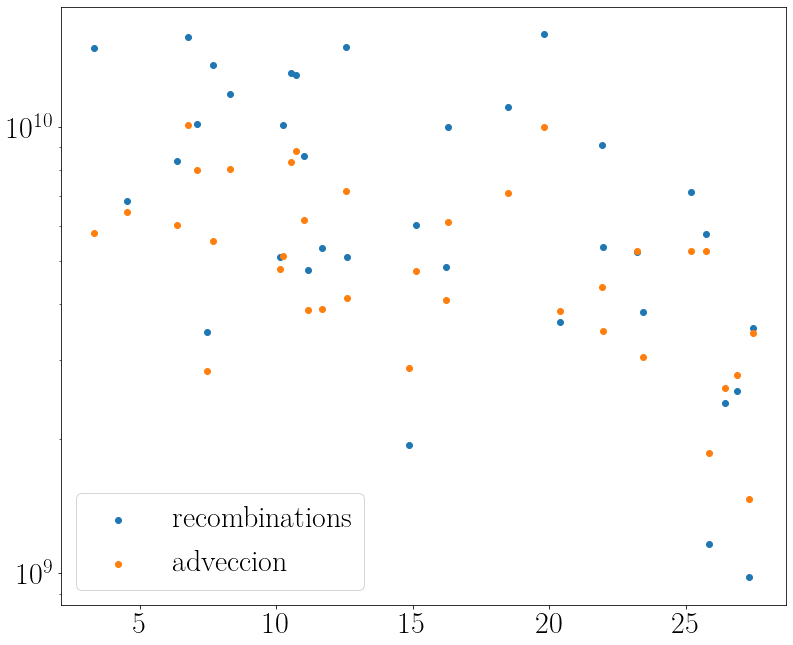

In [239]:
plt.scatter(r0['Sep'][Glo],F0_2[Glo].cgs,label='recombinations')
plt.scatter(r0['Sep'][Glo],F_ad[Glo].cgs,label='adveccion')
plt.legend()
plt.yscale('log')

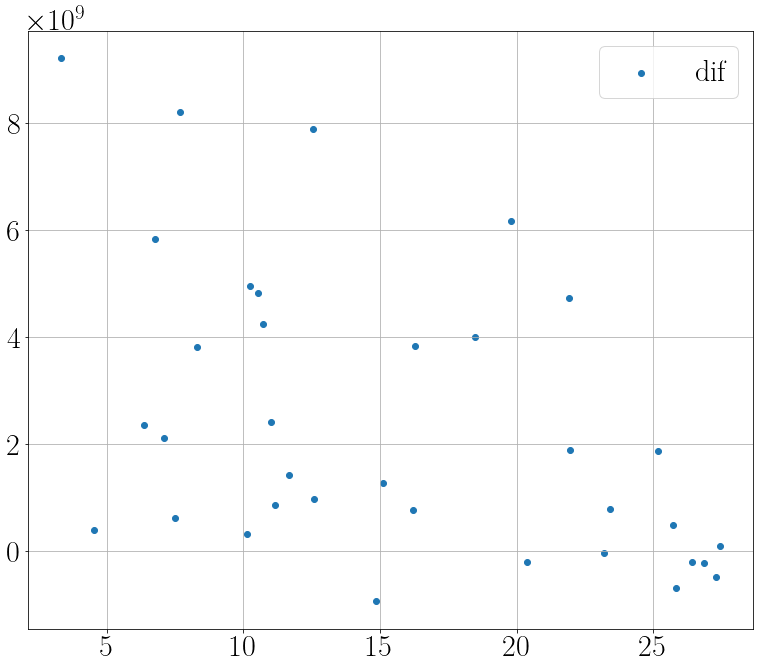

In [243]:
plt.scatter(r0['Sep'][Glo],F0_2[Glo].cgs-F_ad[Glo].cgs,label='dif')
plt.legend()
plt.grid()
#plt.yscale('log')